# Hands-On project: Reach for the Stars??

- For the Hands-On project I have chosen to use the Stellar Classification dataset from Kaggle as my choice of dataset for the project.

- "The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns and 1 class column which identifies it to be either a star, galaxy or quasar." - Kaggle

- I will be performing EDA and Classification on the dataset using PySpark.


## J2 Instance Setup
- Since I plan on performing ML and EDA on a fairly larger dataset I have chosen to use the m3.quad setting with 60 GB volume to accomodate for any installations of libraries.
- First step was to install anacond and getting jupyter notebook and needed libraries to be updated using the following tutorial: https://www.digitalocean.com/community/tutorials/how-to-install-anaconda-on-ubuntu-18-04-quickstart
- Additionally, also needed to run a few bash commads like:
    ```sh

        sudo nano ~/.bashrc

        #Add the following to the .bashrc file
        export PATH=~/anaconda3/bin:$PATH

        # run the following commands
        source ~/anaconda3/etc/profile.d/conda.sh
        . ~/.bashrc
        #In conda env add the needed channels for the library installations
        conda config --add channels conda-forge, esri, menpo etc.
        
    ```
- The libraries installed is exported in the environment.yaml file provided.
- kaggle api is used to get the dataset into local folder structure.

## Importing libraries and setting up environment

In [1]:
#Pyspark path setup command
import findspark
findspark.init()

In [2]:
#Importing librarires that are going to be used for the project
import time
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler,MinMaxScaler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set(rc = {'figure.figsize':(12,7)})

## Initializing the spark session

In [3]:
spark = SparkSession.builder.appName('Reach for the Stars').getOrCreate()
#suppress warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/29 09:31:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Downloading and extracting the dataset 

In [4]:
!kaggle datasets list -s "Stellar Classification" 

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
fedesoriano/stellar-classification-dataset-sdss17              Stellar Classification Dataset - SDSS17               7MB  2022-01-15 17:11:30           6653        182  1.0              
vinesmsuic/star-categorization-giants-and-dwarfs               Star Dataset for Stellar Classification               2MB  2020-08-21 14:10:42           3140         57  1.0              
fedesoriano/stroke-prediction-dataset                          Stroke Prediction Dataset                            67KB  2021-01-26 19:29:28         124695       2618  1.0              
fedesoriano/heart-failure-prediction                           He

In [5]:
!kaggle datasets download -d "fedesoriano/stellar-classification-dataset-sdss17"

stellar-classification-dataset-sdss17.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#https://stackoverflow.com/questions/3451111/unzipping-files-in-python
import zipfile
with zipfile.ZipFile("stellar-classification-dataset-sdss17.zip","r") as zip_ref:
    zip_ref.extractall("Dataset")

## Loading the Data into a Spark RDD

In [7]:
Star_rawDF = spark.read.csv('./Dataset/star_classification.csv', header=True, inferSchema=True)

## First looks at the dataset

In [8]:
Star_rawDF.show(5)

+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+---------+-----+-----+--------+
|              obj_ID|           alpha|             delta|       u|       g|       r|       i|       z|run_ID|rerun_ID|cam_col|field_ID|         spec_obj_ID| class| redshift|plate|  MJD|fiber_ID|
+--------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+--------------------+------+---------+-----+-----+--------+
|1.237660961327743...|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|  3606|     301|      2|      79|6.543777369295181...|GALAXY|0.6347936| 5812|56354|     171|
|1.237664879951151...|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|  4518|     301|      5|     119|1.176014203670733...|GALAXY| 0.779136|10445|58158|     427|
|1.237660961330430..

## By looking at the schema we can see the datatype of each column

In [9]:
Star_rawDF.printSchema()

root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)



### From the Kaggle description we have:
- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS

- alpha = Right Ascension angle (at J2000 epoch)

- delta = Declination angle (at J2000 epoch)

- u = Ultraviolet filter in the photometric system

- g = Green filter in the photometric system

- r = Red filter in the photometric system

- i = Near Infrared filter in the photometric system

- z = Infrared filter in the photometric system

- run_ID = Run Number used to identify the specific scan

- rereun_ID = Rerun Number to specify how the image was processed

- cam_col = Camera column to identify the scanline within the run

- field_ID = Field number to identify each field

- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)

- class = object class (galaxy, star or quasar object)

- redshift = redshift value based on the increase in wavelength

- plate = plate ID, identifies each plate in SDSS

- MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [10]:
#Null value checking
Star_rawDF.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in Star_rawDF.columns)).show()

+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|obj_ID|alpha|delta|  u|  g|  r|  i|  z|run_ID|rerun_ID|cam_col|field_ID|spec_obj_ID|class|redshift|plate|MJD|fiber_ID|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+
|     0|    0|    0|  0|  0|  0|  0|  0|     0|       0|      0|       0|          0|    0|       0|    0|  0|       0|
+------+-----+-----+---+---+---+---+---+------+--------+-------+--------+-----------+-----+--------+-----+---+--------+



In [11]:
#Valid values 
Star_rawDF.select(*(sum(col(c).isNotNull().cast("int")).alias(c) for c in Star_rawDF.columns)).show()

+------+------+------+------+------+------+------+------+------+--------+-------+--------+-----------+------+--------+------+------+--------+
|obj_ID| alpha| delta|     u|     g|     r|     i|     z|run_ID|rerun_ID|cam_col|field_ID|spec_obj_ID| class|redshift| plate|   MJD|fiber_ID|
+------+------+------+------+------+------+------+------+------+--------+-------+--------+-----------+------+--------+------+------+--------+
|100000|100000|100000|100000|100000|100000|100000|100000|100000|  100000| 100000|  100000|     100000|100000|  100000|100000|100000|  100000|
+------+------+------+------+------+------+------+------+------+--------+-------+--------+-----------+------+--------+------+------+--------+



### From the schema we and the descriptions we know that our target variable is class therefore we could group the dataset based on the class to check for class bias/imbalance

In [12]:
Star_rawDF.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|59445|
|   QSO|18961|
|  STAR|21594|
+------+-----+



In [13]:
Unique_vals = Star_rawDF.select('class').distinct().rdd.flatMap(lambda x: x).collect()
ClassbiasDict = {key:Star_rawDF.filter(col("class") == key).count() for key in Unique_vals}
ClassbiasDict

{'GALAXY': 59445, 'QSO': 18961, 'STAR': 21594}

### Class Distribution visualizations

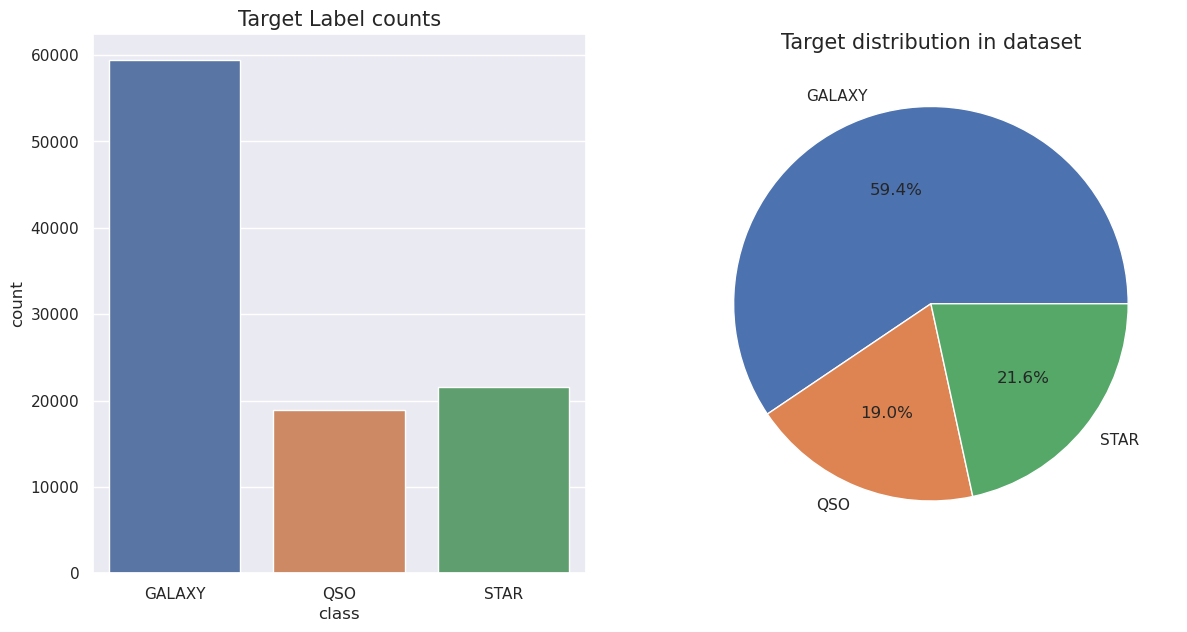

In [14]:
Target_DF = Star_rawDF.groupBy("class").count().withColumn("Percentage", col("count")/Star_rawDF.count()*100).toPandas()
plt.figure(figsize=(14,7))
plt.subplot(121)
bars = sns.barplot(x="class", y='count', data=Target_DF)
plt.title(label='Target Label counts', fontsize=15)
plt.subplot(122)
plt.pie(x='Percentage', labels=Unique_vals, data=Target_DF, autopct='%1.1f%%')
plt.title(label='Target distribution in dataset', fontsize=15)
plt.show()

- Clearly we have a imbalance towards "GALAXY" class as compared to the QSO or STAR class

### To mitigate this type of class bias we can perform over or undersampling of dataset to achieve more equatable distribution
- Here I have chosen to demonstrate Undersampling.
- However, since the dataset reflects effective reality of the classification I am choosing to keep the imabalance for the classifcation.
- Also using the data set with and without sampling will grossly affect the decision for feature selection so it would be advisable to be using the entirity of the dataset instead of random sampling.
- Both samples will be displayed for Correlation visualization.

In [15]:
Star_UnderSampledDF = Star_rawDF.sampleBy('class', fractions={'GALAXY':  ClassbiasDict['QSO']/ClassbiasDict["GALAXY"], 'QSO':1.0, 'STAR': ClassbiasDict['QSO']/ClassbiasDict["STAR"]}, seed=42)

In [16]:
Star_UnderSampledDF.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|19061|
|   QSO|18961|
|  STAR|18960|
+------+-----+



## EDA and data preprocessing for ML

In [17]:
from pyspark.ml import Pipeline

#Use StringIndexer to x categorical columns to indicesx for complete dataset
indexers = [StringIndexer(inputCol=col, outputCol=col+"_enc") for col in ['class']]
indexer_pipeline = Pipeline(stages=indexers)
Star_indexedDF = indexer_pipeline.fit(Star_rawDF).transform(Star_rawDF)
Star_indexedDF.printSchema()

#Use StringIndexer to x categorical columns to indicesx for undersampled dataset
indexers = [StringIndexer(inputCol=col, outputCol=col+"_enc") for col in ['class']]
indexer_pipeline = Pipeline(stages=indexers)
Star_indexedUDF = indexer_pipeline.fit(Star_UnderSampledDF).transform(Star_UnderSampledDF)
#Star_indexedUDF.printSchema()

root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)
 |-- class_enc: double (nullable = false)



### Dropping the categorical class data snce we have a newly encoded class_encoded column

In [18]:
Star_encodedDF = Star_indexedDF.drop("class")
#Star_encodedDF.printSchema()
Star_encodedUDF = Star_indexedUDF.drop("class")
#Star_encodedUDF.printSchema()

In [19]:
# GALAXY = 0, STAR = 1, OSQ = 2
Star_encodedDF.groupBy("class_enc").count().show()

+---------+-----+
|class_enc|count|
+---------+-----+
|      0.0|59445|
|      1.0|21594|
|      2.0|18961|
+---------+-----+



<AxesSubplot:>

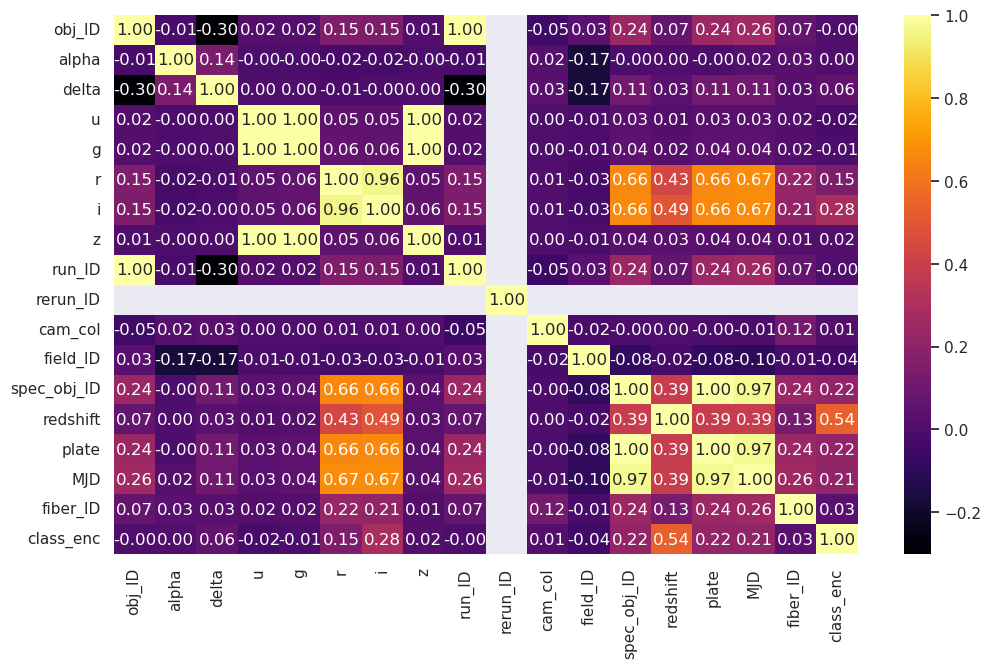

In [20]:
assembler = VectorAssembler(inputCols=Star_encodedDF.columns, outputCol="features")
Star_assembledDF = assembler.transform(Star_encodedDF)

# Calculate the correlation matrix
Star_corr_matrix = Correlation.corr(Star_assembledDF, "features")

# Extract the matrix values
corr_matrix = Star_corr_matrix.collect()[0]["pearson(features)"].toArray()

# Convert the matrix to a Pandas dataframe
corr_df = pd.DataFrame(corr_matrix, columns=Star_encodedDF.columns, index=Star_encodedDF.columns)

# Generate the heatmap using Seaborn
sns.heatmap(corr_df, cmap="inferno", annot=True, fmt=".2f")

<AxesSubplot:>

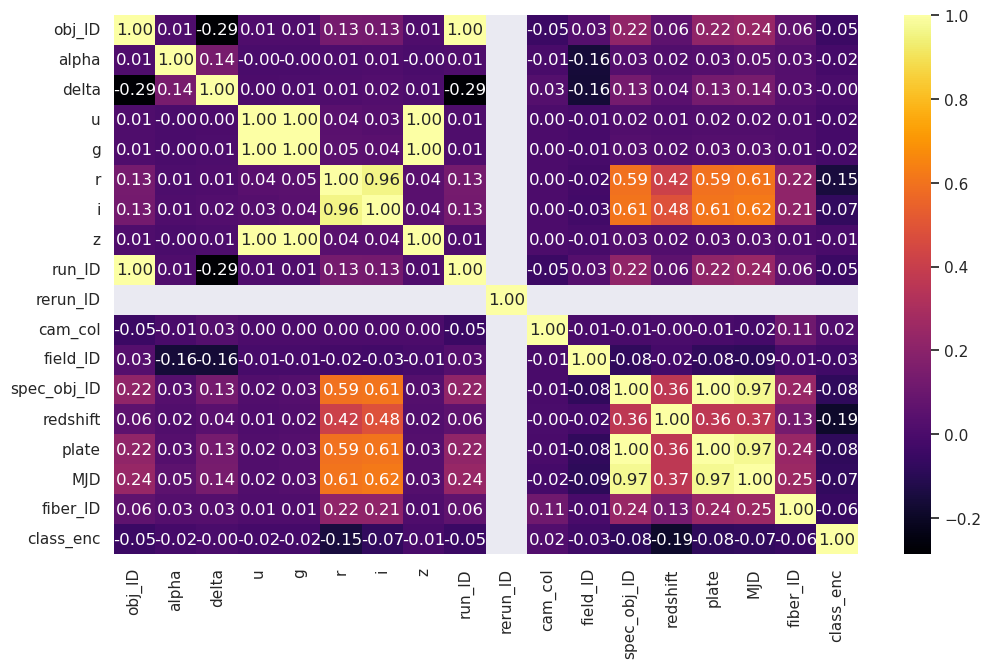

In [21]:
assembler = VectorAssembler(inputCols=Star_encodedUDF.columns, outputCol="features")
Star_assembledDF = assembler.transform(Star_encodedUDF)

# Calculate the correlation matrix
Star_corr_matrix = Correlation.corr(Star_assembledDF, "features")

# Extract the matrix values
corr_matrix = Star_corr_matrix.collect()[0]["pearson(features)"].toArray()

# Convert the matrix to a Pandas dataframe
corr_df = pd.DataFrame(corr_matrix, columns=Star_encodedUDF.columns, index=Star_encodedUDF.columns)

# Generate the heatmap using Seaborn
sns.heatmap(corr_df, cmap="inferno", annot=True, fmt=".2f")


- As discussed earlier we can aslo see that there seems to be significant variance in the creelation matrix with and without Undersampling therefore I recommend using the supersampling method to boost the other 2 target category values to obtain meaningful correlation however, I am avoiding this due to fear of overfitting data.
- From the above correlation matrix we get a basic idea as to which features seem to be more important than others.
- Also from the descriptions and some research over the variables we can infer which features are more important to the task of classification.
- I have chosen to go ahead with the following columns to proceed with.

In [22]:
Meaningful_cols = ['alpha','delta', 'u', 'g', 'r', 'i', 'z', 'redshift','plate', 'MJD','class_enc']
#Dropping the not so meaningful columns
for Column in Star_encodedDF.columns:
    if Column not in Meaningful_cols:
        Star_encodedDF = Star_encodedDF.drop(Column)
Star_KeyDF = Star_encodedDF
Star_KeyDF.printSchema()

root
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- class_enc: double (nullable = false)



## Time for some feature engineering and cleaning

In [23]:
#Converting the data into pandas DF for plotting and visualization
PlotDF = Star_KeyDF.toPandas()

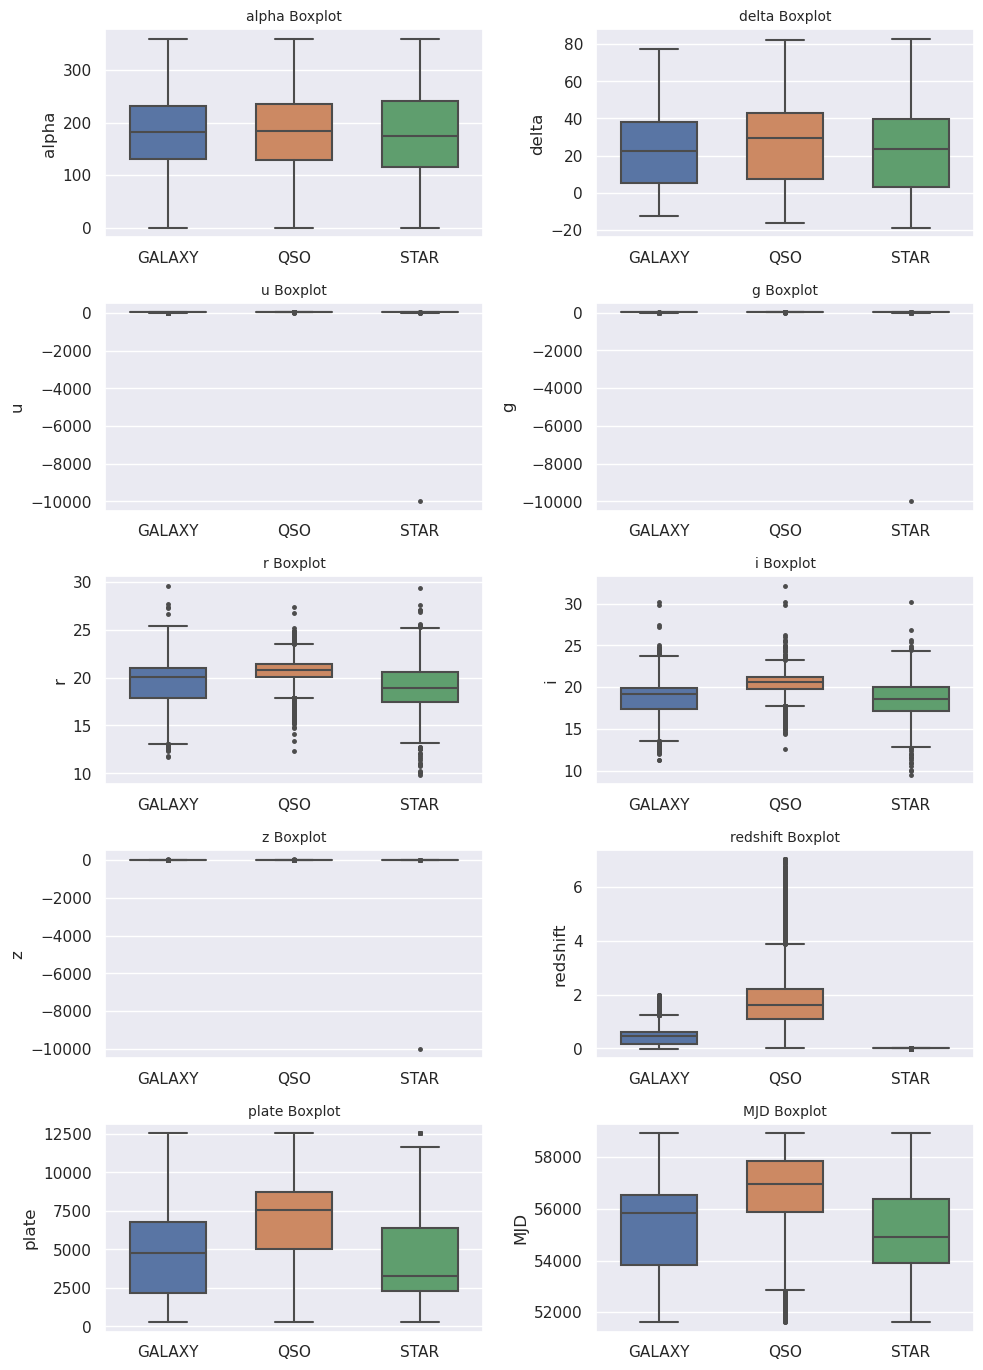

In [24]:
#reference: https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html
plot_features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD']
class_map = {0: 'GALAXY', 2: 'QSO', 1: 'STAR'}
plt.figure(figsize=(10, 30))
for (_, col) in zip(range(len(plot_features)), plot_features):
    plt.subplot(len(Meaningful_cols), 2, _+1)
    sns.boxplot(x=PlotDF['class_enc'].map(class_map), y=col, data=PlotDF,
                width=0.6, flierprops={'marker': '.'})
    plt.title(label='{} Boxplot'.format(col), fontsize=10)
    plt.xlabel(xlabel=None)
    _ += 1
plt.tight_layout()
plt.show()

## From the box plots we get to see the Data Quality of the feature and infer the following

- We can see that the 'u','g','z','plate' feature seems to have a clear outlier value in the STAR label data.
- The 'redshift' plot has majority values as 0 for the STAR label however, this may be regarded as a key factor of classification as STAR.
- The other features clearly seem to be within acceptable range with tolerance for some outliers.

## Outlier removal

- We need to look at th min value to see the record number in the dataframe for the outlier.

In [25]:
PlotDF['u'].idxmin(),PlotDF['g'].idxmin(),PlotDF['z'].idxmin()
#As we can see we need to remove the 79543th entry
PlotDF = PlotDF.drop(index=[79543])

In [26]:
try:
    PlotDF['u'][79543]
except:
    print("Index Removed")

Index Removed


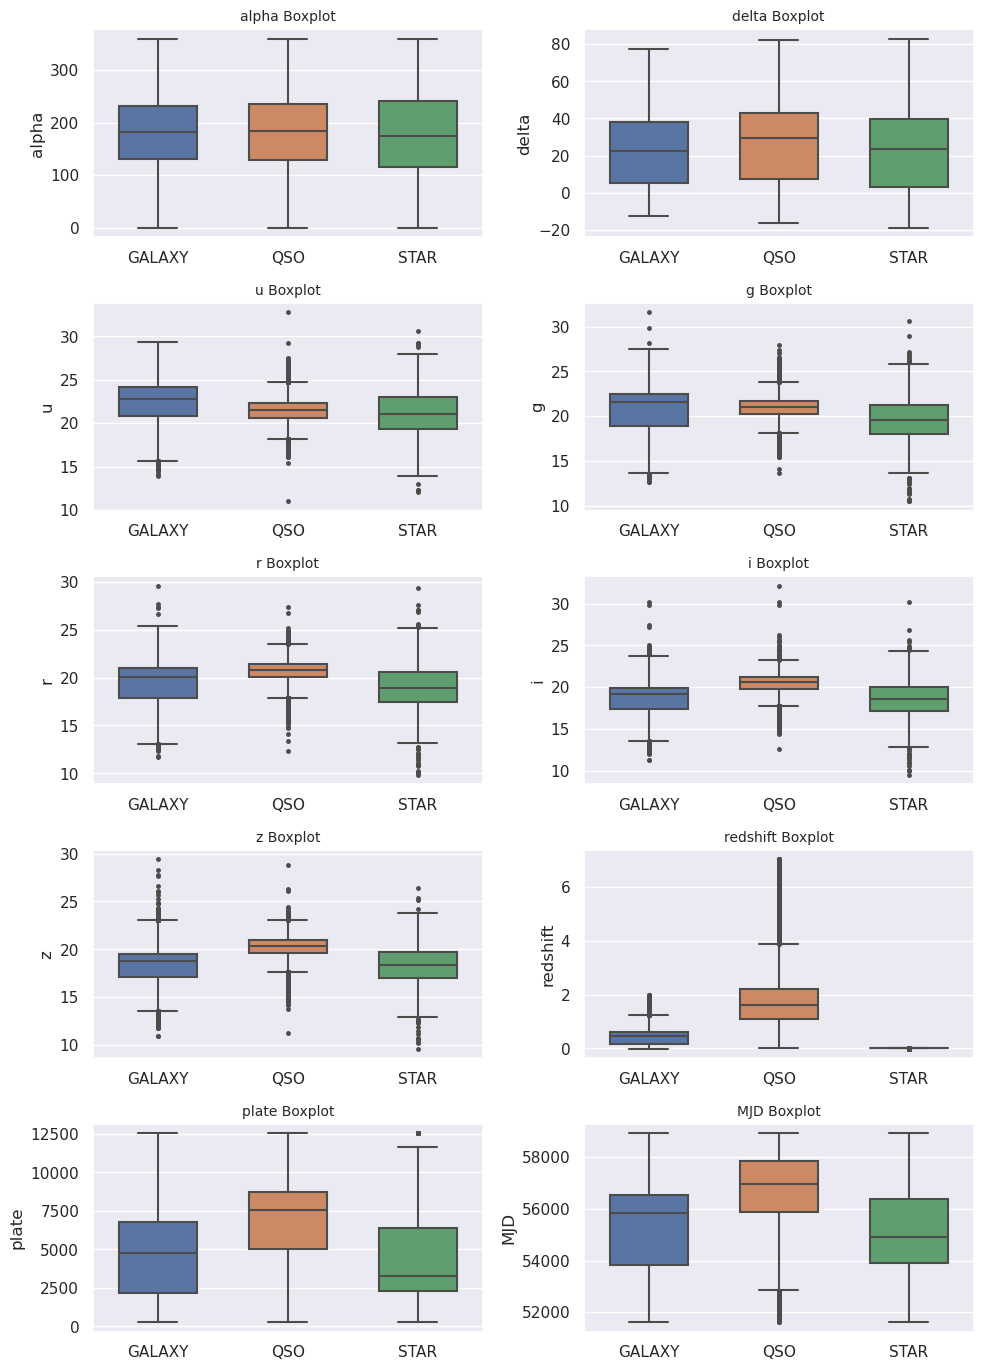

In [27]:
#reference: https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html
plot_features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'plate', 'MJD']
class_map = {0: 'GALAXY', 2: 'QSO', 1: 'STAR'}
plt.figure(figsize=(10, 30))
for (_, col) in zip(range(len(plot_features)), plot_features):
    plt.subplot(len(Meaningful_cols), 2, _+1)
    sns.boxplot(x=PlotDF['class_enc'].map(class_map), y=col, data=PlotDF,
                width=0.6, flierprops={'marker': '.'})
    plt.title(label='{} Boxplot'.format(col), fontsize=10)
    plt.xlabel(xlabel=None)
    _ += 1
plt.tight_layout()
plt.show()

### Converting the pandas back to spark RDD

In [28]:
PlotDF.reset_index(inplace=True, drop=True)
PlotDF

,alpha,delta,u,g,r,i,z,redshift,plate,MJD,class_enc
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354,0.0
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158,0.0
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592,0.0
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039,0.0
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99994,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749,0.0
99995,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934,0.0
99996,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535,0.0
99997,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368,0.0


In [29]:
Star_cleanDF = spark.createDataFrame(PlotDF)

In [30]:
Star_cleanDF.printSchema()
Star_cleanDF.show(5)

root
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: long (nullable = true)
 |-- MJD: long (nullable = true)
 |-- class_enc: double (nullable = true)

+----------------+------------------+--------+--------+--------+--------+--------+---------+-----+-----+---------+
|           alpha|             delta|       u|       g|       r|       i|       z| redshift|plate|  MJD|class_enc|
+----------------+------------------+--------+--------+--------+--------+--------+---------+-----+-----+---------+
|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|0.6347936| 5812|56354|      0.0|
|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427| 0.779136|10445|58158|      0.0|
|142.188789562506|  35.58244418

### Now the Features seem more reasonable to operate upon and we can start Feature visualization

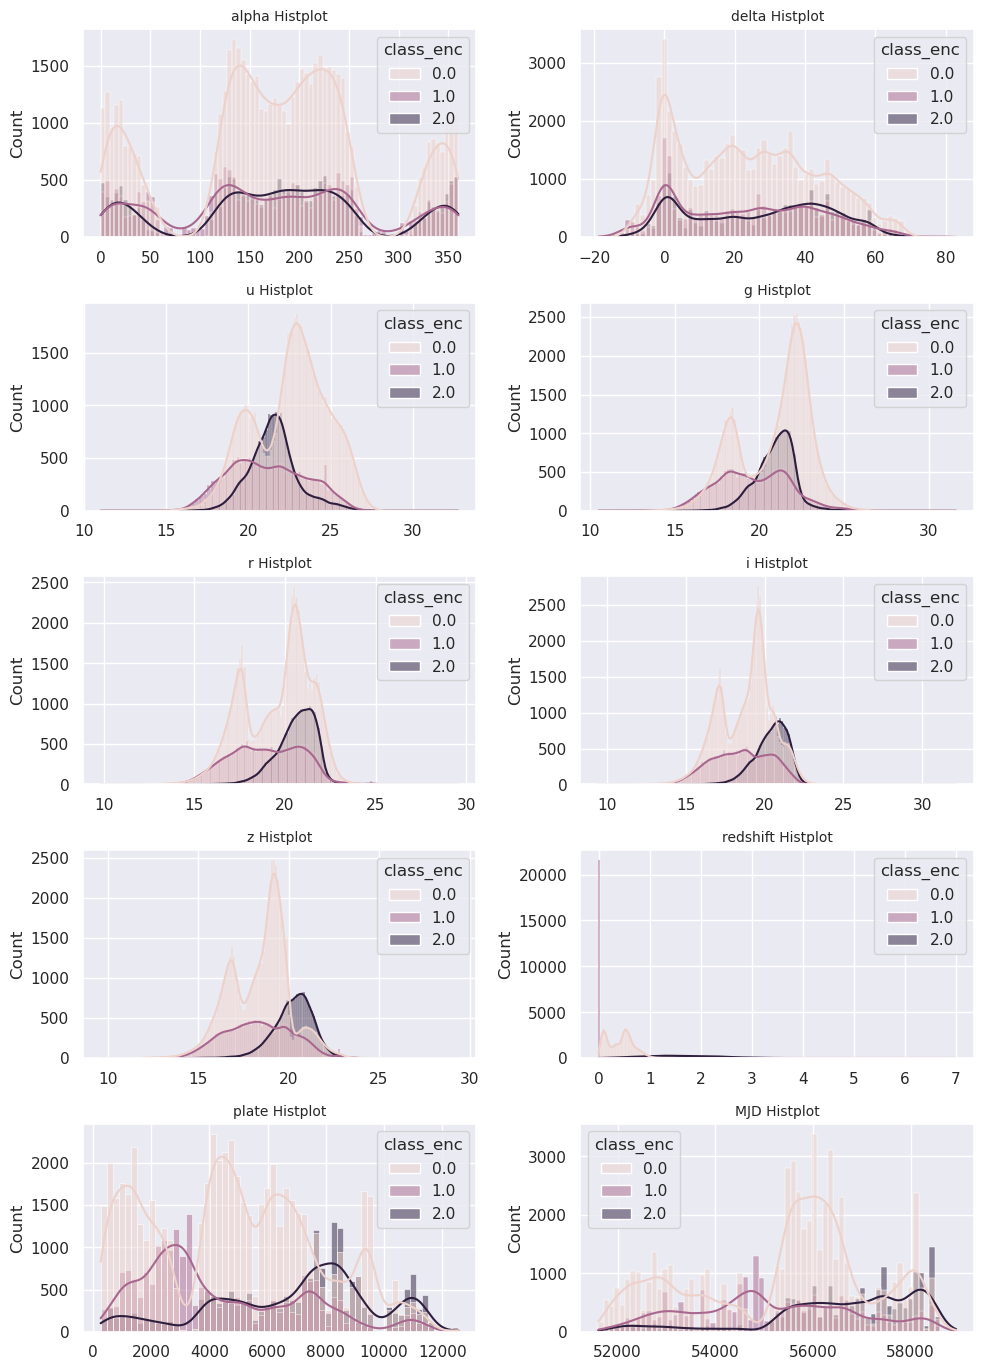

In [31]:
class_map = {0: 'GALAXY', 2: 'QSO', 1: 'STAR'}
plt.figure(figsize=(10, 30))
for (_, col) in zip(range(len(plot_features)), plot_features):
    plt.subplot(len(Meaningful_cols), 2, _+1)
    sns.histplot(data=PlotDF, x=col, kde=True, hue="class_enc")
    plt.title(label='{} Histplot'.format(col), fontsize=10)
    plt.xlabel(xlabel=None)
    _ += 1
plt.tight_layout()
plt.show()

### Due to the magnitude in redshift we are getting smaller graph which can be fixed by using log scaling of data

- Now going back to correlation mapping let's have a look at the correlation map of the final feature to see if there is any improvement in the observed correlations by using Heatmaps and pairplots.


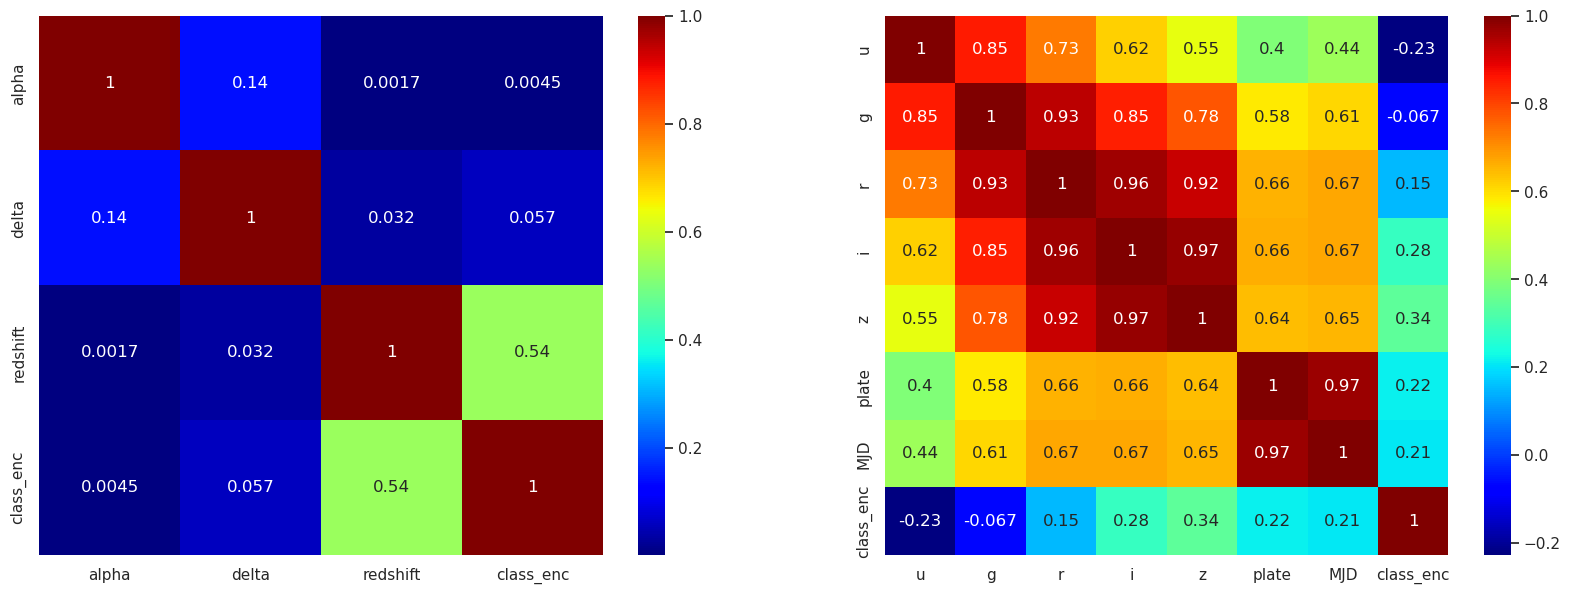

In [32]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
sns.heatmap(data=PlotDF[['alpha', 'delta', 'redshift','class_enc']].corr(),annot=True,cmap="jet")
plt.subplot(122)
sns.heatmap(data=PlotDF[['u', 'g', 'r', 'i', 'z','plate', 'MJD','class_enc']].corr(),annot=True,cmap="jet")
plt.show()

- For the angular features like 'alpha', 'delta' there isn't much indicated corellation other than redshift.
- For the 'u', 'g', 'r', 'i', 'z','plate', and 'MJD' features there is significantly more correlation most of them being positive.
- At this point it would be safe to drop the 'alpha' and 'delta' features to reduce load on the classification task.

<Figure size 1200x700 with 0 Axes>

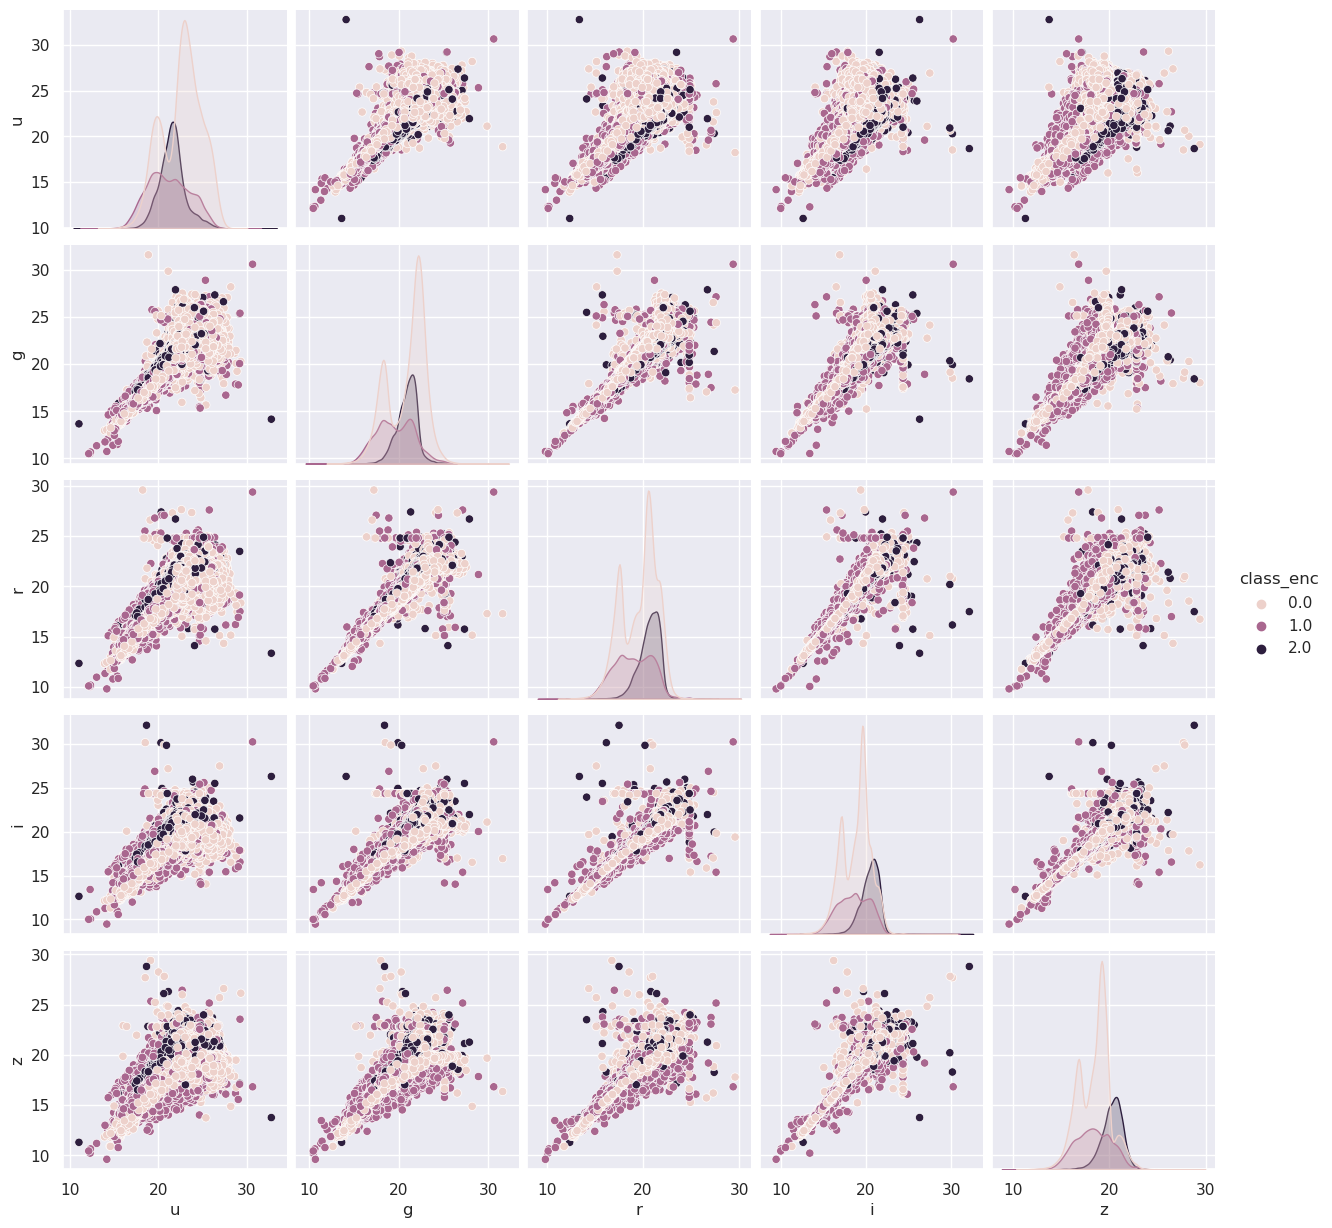

<Figure size 1200x700 with 0 Axes>

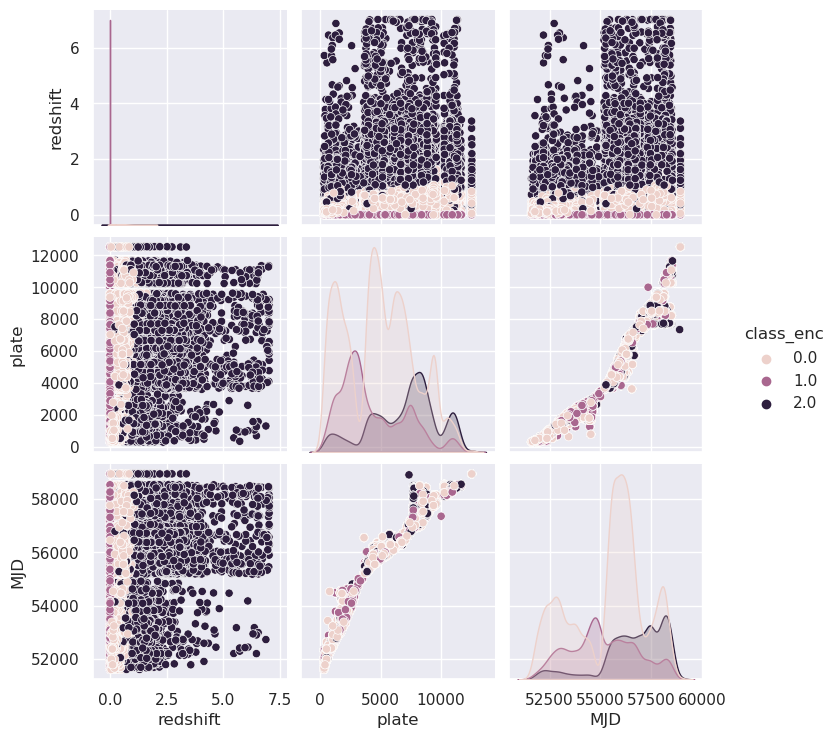

In [43]:
#Filter features 
plt.figure()
pp = sns.pairplot(data=PlotDF[['u', 'g', 'r', 'i', 'z', 'class_enc']], hue='class_enc')
plt.show()

#Unique features
plt.figure()
pp = sns.pairplot(data=PlotDF[['redshift','plate','MJD','class_enc']], hue='class_enc')
plt.show()

- As can be seen from the pair plots there seems to be obvious positive correlation between the 'u', 'g', 'r', 'i', 'z' and the labels and some arbitrary correlations between 'plate','MJD' features which leads us to further drop the columns of 'alpha','delta','plate','MJD' 

- Also, after running the models multiple time clearly the 'plate','MJD' seem to reduce the ability of MLP to classify which gives the evidence for cause for removal of columns 

In [34]:
Star_MLDF = Star_cleanDF.drop(*['alpha','delta','plate','MJD'])
#renaming class_enc as label to avoid issues with MLP classifier
Star_MLDF = Star_MLDF.withColumnRenamed("class_enc","label")
Star_MLDF.printSchema()

root
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- redshift: double (nullable = true)
 |-- label: double (nullable = true)



## Machine Learning for Classification using various models

In [35]:
from pyspark.ml.feature import  StandardScaler, PCA
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes,MultilayerPerceptronClassifier,LinearSVC,OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

#Reference: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification
#https://spark.apache.org/docs/latest/ml-classification-regression.html

# Split the data into training and testing sets
(training_data, testing_data) = Star_MLDF.randomSplit([0.7, 0.3], seed=42)

# Assemble features into a single column
FeatAssm = VectorAssembler(inputCols=Star_MLDF.columns[:-1], outputCol="features")

# Standard Normalize the features
StdScale = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# MinMax Normalize the features
MinMax = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

layers = [len(Star_MLDF.columns[:-1]),32,16,8,4,3]

# Create logistic regression model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="label")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
ovr = OneVsRest(featuresCol='scaledFeatures', labelCol = 'label',classifier=lr)
nb = NaiveBayes(featuresCol="scaledFeatures", labelCol="label", modelType="gaussian")
mlp = MultilayerPerceptronClassifier(layers=layers,blockSize=256,seed=42)


#Creating the pipeline for ML Execution for all models with varied operations based on model requirements
pipeline_lr = Pipeline(stages=[FeatAssm, StdScale, lr])
pipeline_dt = Pipeline(stages=[FeatAssm, dt])
pipeline_rf = Pipeline(stages=[FeatAssm, rf])
pipeline_ovr = Pipeline(stages=[FeatAssm, StdScale, ovr])
pipeline_nb = Pipeline(stages=[FeatAssm,MinMax,nb])
pipeline_mlp = Pipeline(stages=[FeatAssm, mlp])


In [36]:
training_data.show(5)
testing_data.show(5)

+--------+--------+--------+--------+--------+------------+-----+
|       u|       g|       r|       i|       z|    redshift|label|
+--------+--------+--------+--------+--------+------------+-----+
| 12.2624|10.51139|10.06854|13.41786|10.22551| 2.498567E-5|  1.0|
|14.15199|10.73097| 9.82207|9.469903|9.612333| 5.092877E-5|  1.0|
|14.50678|12.67902|11.74664|11.29956|10.91847| 0.007589578|  0.0|
|14.56906|13.06488|12.52759| 12.5511|12.32606|-1.597281E-4|  1.0|
|14.64617|15.04207|15.46415|15.75953|16.00825|-1.741084E-4|  1.0|
+--------+--------+--------+--------+--------+------------+-----+
only showing top 5 rows

+--------+--------+--------+--------+--------+------------+-----+
|       u|       g|       r|       i|       z|    redshift|label|
+--------+--------+--------+--------+--------+------------+-----+
|14.26381|12.03599|11.64166|11.51527|12.55128| 1.579277E-4|  1.0|
|14.64972|12.63574| 12.1434|11.96598|13.13046| 2.895463E-4|  1.0|
|14.92536| 13.5602|13.10489|12.83076|12.64798| 0.00

## Hyper Parameter tuning

In [37]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#Reference: https://spark.apache.org/docs/latest/ml-tuning.html
#https://stackoverflow.com/questions/65655906/hypertuning-a-logistic-regression-pipeline-model-in-pyspark

# Logistic regression tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [100, 150]) \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.5, 1.0]) \
    .build()

AccEval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create cross-validator
crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=AccEval,
                          numFolds=5)

# Decision tree tuning
paramGrid_dt = ParamGridBuilder() \
             .addGrid(dt.maxDepth, [ 10, 20, 30]) \
             .addGrid(dt.impurity, ['gini', 'entropy']) \
             .build()

# Create 5-fold CrossValidator
crossval_dt = CrossValidator(estimator = pipeline_dt,
                      estimatorParamMaps = paramGrid_dt,
                      evaluator = AccEval,
                      numFolds = 5)

# Random Forest tuning
paramGrid_rf = ParamGridBuilder() \
            .addGrid(rf.numTrees, [50, 100]) \
            .addGrid(rf.maxDepth, [5, 10, 15]) \
            .build()

# Create cross-validator
crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=AccEval,
                          numFolds=5)

# # One V Rest  tuning
# paramGrid_rf = ParamGridBuilder() \
#             .addGrid(rf.numTrees, [10, 50, 100]) \
#             .addGrid(rf.maxDepth, [10, 15, 25]) \
#             .build()

# # Create cross-validator
# crossval_rf = CrossValidator(estimator=pipeline_rf,
#                           estimatorParamMaps=paramGrid_rf,
#                           evaluator=AccEval,
#                           numFolds=5)

# Naive Bayes tuning
paramGrid_nb = ParamGridBuilder() \
            .addGrid(nb.smoothing, [0.1,0.5,1.0,1.5,2.0,2.5]) \
            .build()

# Create cross-validator
crossval_nb = CrossValidator(estimator=pipeline_nb,
                          estimatorParamMaps=paramGrid_nb,
                          evaluator=AccEval,
                          numFolds=5)

# # MLP tuning
# paramGrid_mlp = ParamGridBuilder() \
#             .addGrid(mlp.blockSize, [128, 256]) \
#             .build()

# # Create cross-validator
# crossval_mlp = CrossValidator(estimator=pipeline_mlp,
#                           estimatorParamMaps=paramGrid_rf,
#                           evaluator=AccEval,
#                           numFolds=3)


## Model training

In [38]:
start_time = time.time()
model_lr = crossval_lr.fit(training_data)
lr_time = time.time()
print("|----------Logistic Regression Model trained in {:.2f} seconds------------|".format(lr_time - start_time))
model_dt = crossval_dt.fit(training_data)
dt_time = time.time()
print("|----------Decision Tree Model trained in {:.2f} seconds------------|".format(dt_time - lr_time))
model_rf = crossval_rf.fit(training_data)
rf_time = time.time()
print("|----------Random Forest Model trained in {:.2f} seconds------------|".format(rf_time - dt_time))
model_ovr = pipeline_ovr.fit(training_data)
ovr_time = time.time()
print("|----------One vs Rest using LogR Model trained in {:.2f} seconds------------|".format(ovr_time - rf_time))
model_nb = crossval_nb.fit(training_data)
nb_time = time.time()
print("|----------Naive Bayes Model trained in {:.2f} seconds------------|".format(nb_time - ovr_time))
model_mlp = pipeline_mlp.fit(training_data)
mlp_time = time.time()
print("|----------MLP Model trained in {:.2f} seconds------------|".format(mlp_time - nb_time))

|----------Logistic Regression Model trained in 141.70 seconds------------|
|----------Decision Tree Model trained in 48.88 seconds------------|


|----------Random Forest Model trained in 408.39 seconds------------|
|----------One vs Rest using LogR Model trained in 5.79 seconds------------|
|----------Naive Bayes Model trained in 15.05 seconds------------|


|----------MLP Model trained in 11.40 seconds------------|


## Model test data predicition and accuracy preview

In [39]:
predictions_lr = model_lr.transform(testing_data)
print("|----------Logistic Regression Model prediction complete------------|")
predictions_dt = model_dt.transform(testing_data)
print("|----------Decision Tree Model prediction complete------------|")
predictions_rf = model_rf.transform(testing_data)
print("|----------Random Forest Model prediction complete------------|")
predictions_ovr = model_ovr.transform(testing_data)
print("|----------One vs Rest using LogR Model prediction complete------------|")
predictions_nb = model_nb.transform(testing_data)
print("|----------Naive Bayes (Gaussian) prediction complete------------|")
predictions_mlp = model_mlp.transform(testing_data)
print("|----------MLP Model prediction complete------------|")
print("\n\n")

# Evaluate the model using Multi class evaluater
MCeval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


LR_acc = MCeval.evaluate(predictions_lr)
DT_acc = MCeval.evaluate(predictions_dt)
RF_acc = MCeval.evaluate(predictions_rf)
OVR_acc = MCeval.evaluate(predictions_ovr)
NB_acc = MCeval.evaluate(predictions_nb)
MLP_acc = MCeval.evaluate(predictions_mlp)

print("LogisticRegModel Accuracy = {:.2f}%".format(LR_acc * 100))
print("DecisionTreeModel Accuracy = {:.2f}%".format(DT_acc * 100))
print("RandomForestModel Accuracy = {:.2f}%".format(RF_acc * 100))
print("OneVRest Accuracy = {:.2f}%".format(OVR_acc * 100))
print("NaiveBayes Accuracy = {:.2f}%".format(NB_acc * 100))
print("MultiLayerPerceptron Accuracy = {:.2f}%".format(MLP_acc * 100))


|----------Logistic Regression Model prediction complete------------|
|----------Decision Tree Model prediction complete------------|
|----------Random Forest Model prediction complete------------|
|----------One vs Rest using LogR Model prediction complete------------|
|----------Naive Bayes (Gaussian) prediction complete------------|
|----------MLP Model prediction complete------------|





LogisticRegModel Accuracy = 92.62%
DecisionTreeModel Accuracy = 96.43%
RandomForestModel Accuracy = 97.01%
OneVRest Accuracy = 95.07%
NaiveBayes Accuracy = 92.08%
MultiLayerPerceptron Accuracy = 80.46%


## F1 result matrix visualization

/home/exouser/anaconda3/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Initialized Classification evaluators




Evaluated Confusion matrices


LogisticRegModel Confusion matrix plot ready


DecisionTreeModel Confusion matrix plot ready


RandomForestModel Confusion matrix plot ready


OneVRest Confusion matrix plot ready


NaiveBayes Confusion matrix plot ready


MultiLayerPerceptron Confusion matrix plot ready




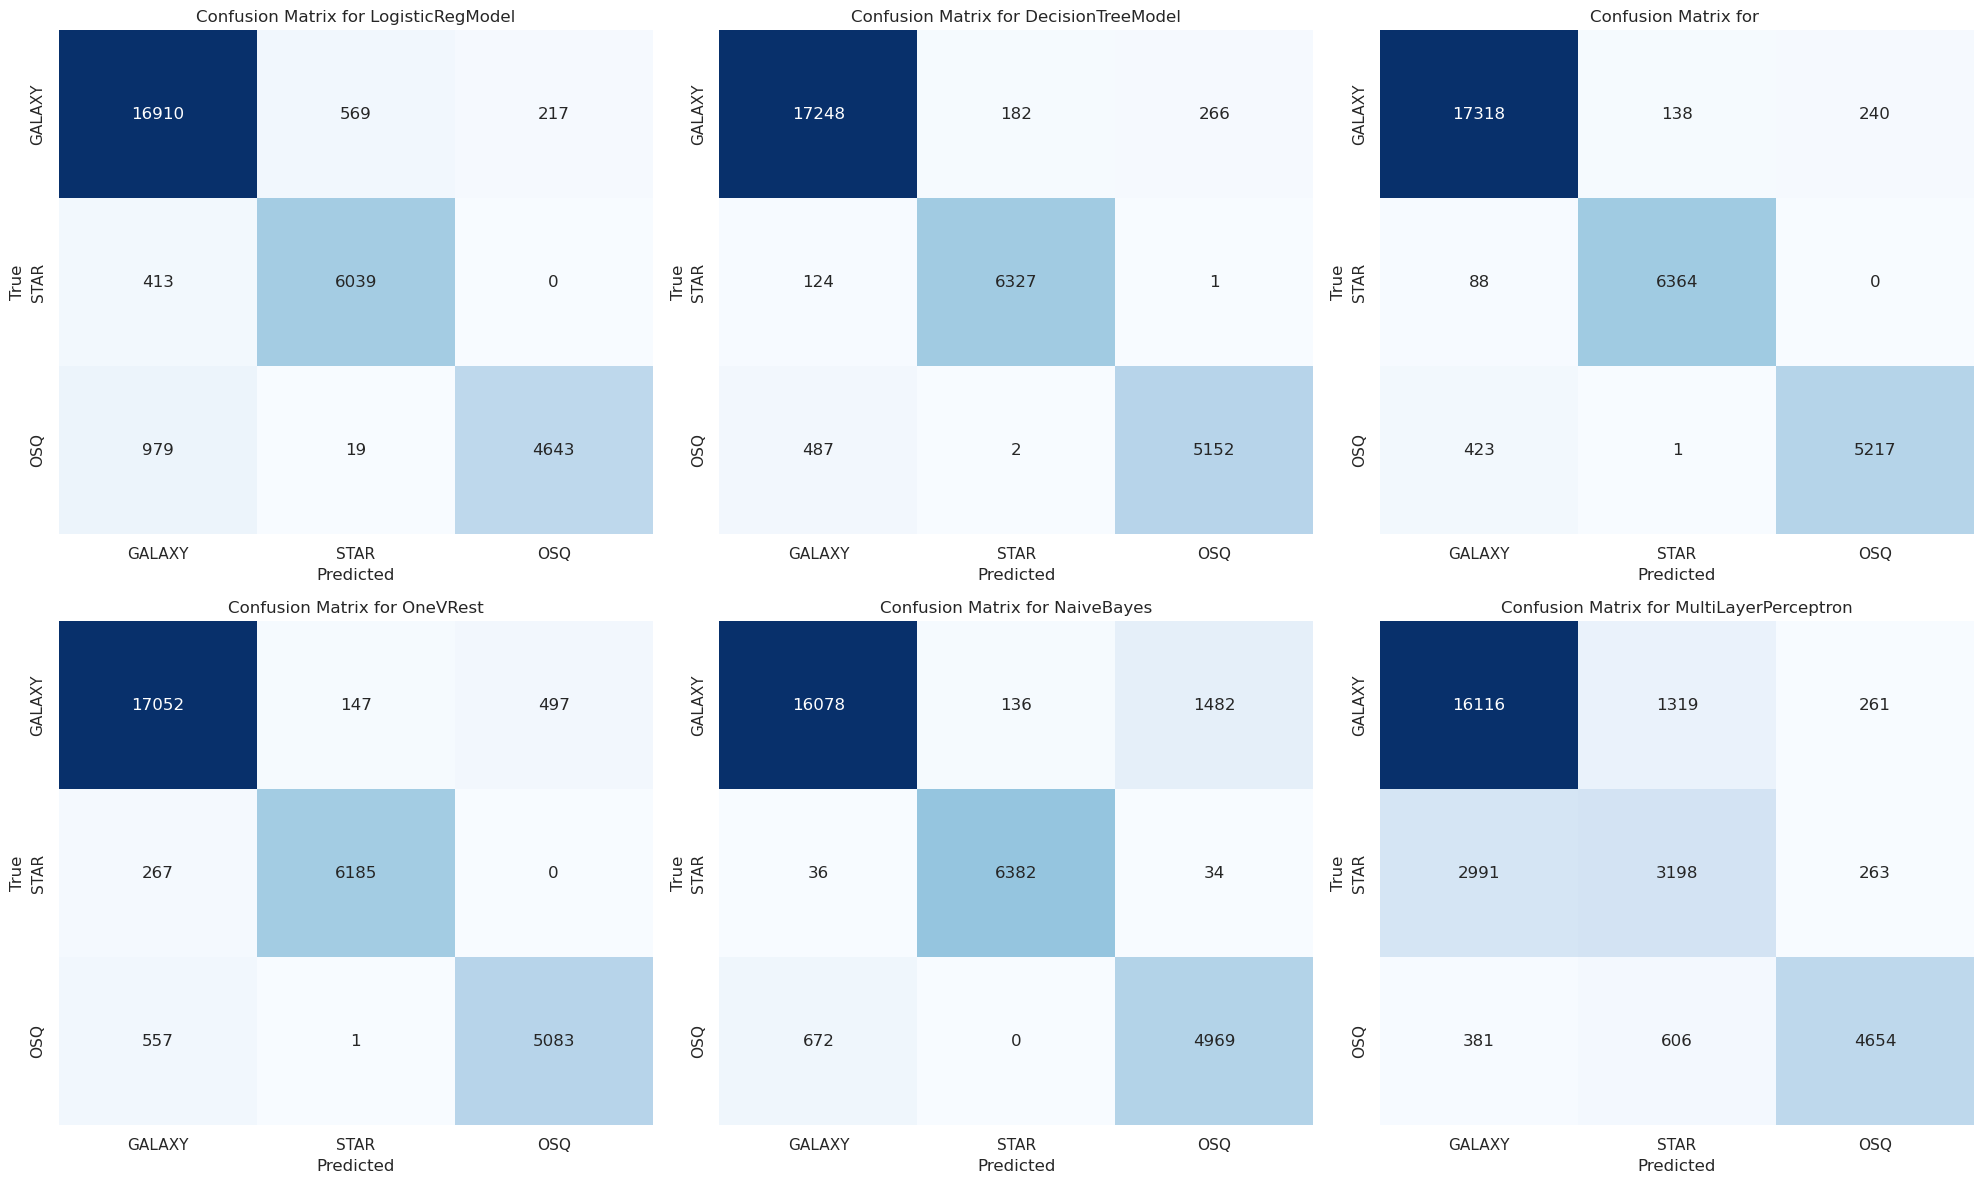

In [40]:
# Prediction and original label segregation
LogisticRegModel_pnl = predictions_lr.select("prediction", "label").rdd
DecisionTreeModel_pnl = predictions_dt.select("prediction", "label").rdd
RandomForestModel_pnl = predictions_rf.select("prediction", "label").rdd
OneVRest_pnl = predictions_ovr.select("prediction", "label").rdd
NaiveBayes_pnl = predictions_nb.select("prediction", "label").rdd
MLP_pnl = predictions_mlp.select("prediction", "label").rdd

# Prediction and original label metric calculation
LR_metrics = MulticlassMetrics(LogisticRegModel_pnl)
DT_metrics = MulticlassMetrics(DecisionTreeModel_pnl)
RF_metrics = MulticlassMetrics(RandomForestModel_pnl)
OVR_metrics = MulticlassMetrics(OneVRest_pnl)
NB_metrics = MulticlassMetrics(NaiveBayes_pnl)
MLP_metrics = MulticlassMetrics(MLP_pnl)
print("Initialized Classification evaluators\n\n")

# Confusion matrices creation
LR_ConfMat = LR_metrics.confusionMatrix().toArray()
DT_ConfMat = DT_metrics.confusionMatrix().toArray()
RF_ConfMat = RF_metrics.confusionMatrix().toArray()
OVR_ConfMat = OVR_metrics.confusionMatrix().toArray()
NB_ConfMat = NB_metrics.confusionMatrix().toArray()
MLP_ConfMat = MLP_metrics.confusionMatrix().toArray()

print("Evaluated Confusion matrices\n\n")

#plotting the matrices
plt.figure(figsize=(20,12))
plt.subplot(231)
sns.heatmap(LR_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LogisticRegModel')

print("LogisticRegModel Confusion matrix plot ready\n\n")

plt.subplot(232)
sns.heatmap(DT_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for DecisionTreeModel')

print("DecisionTreeModel Confusion matrix plot ready\n\n")

plt.subplot(233)
sns.heatmap(RF_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ')

print("RandomForestModel Confusion matrix plot ready\n\n")

plt.subplot(234)
sns.heatmap(OVR_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for OneVRest')

print("OneVRest Confusion matrix plot ready\n\n")

plt.subplot(235)
sns.heatmap(NB_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for NaiveBayes')

print("NaiveBayes Confusion matrix plot ready\n\n")

plt.subplot(236)
sns.heatmap(MLP_ConfMat, annot=True, cmap='Blues', fmt='g',cbar=False, xticklabels=['GALAXY', 'STAR', 'OSQ'], yticklabels=['GALAXY', 'STAR', 'OSQ'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for MultiLayerPerceptron')

print("MultiLayerPerceptron Confusion matrix plot ready\n\n")

plt.tight_layout()
plt.show()


# Classification metrics sevaluators
f1_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")
P_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="precisionByLabel")
R_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="recallByLabel")

LR_f1_score = f1_evaluator.evaluate(predictions_lr)
LR_P_score = P_evaluator.evaluate(predictions_dt)
LR_R_score = R_evaluator.evaluate(predictions_dt)


DT_f1_score = f1_evaluator.evaluate(predictions_dt)
DT_P_score = P_evaluator.evaluate(predictions_dt)
DT_R_score = R_evaluator.evaluate(predictions_dt)


RF_f1_score = f1_evaluator.evaluate(predictions_rf)
RF_P_score = P_evaluator.evaluate(predictions_rf)
RF_R_score = R_evaluator.evaluate(predictions_rf)


OVR_f1_score = f1_evaluator.evaluate(predictions_ovr)
OVR_P_score = P_evaluator.evaluate(predictions_ovr)
OVR_R_score = R_evaluator.evaluate(predictions_ovr)


NB_f1_score = f1_evaluator.evaluate(predictions_nb)
NB_P_score = P_evaluator.evaluate(predictions_nb)
NB_R_score = R_evaluator.evaluate(predictions_nb)


MLP_f1_score = f1_evaluator.evaluate(predictions_mlp)
MLP_P_score = P_evaluator.evaluate(predictions_mlp)
MLP_R_score = R_evaluator.evaluate(predictions_mlp)


headers = ['Model', 'F1 Score','Precision','Recall', 'Accuracy']
Models = ['Logistic Regression', 'Random Forest', 'Decision Tree','One Vs Rest (LR)', 'Naive Bayes', 'Multi Layer Perceptron']
f1_scores = [LR_f1_score, DT_f1_score, RF_f1_score, OVR_f1_score, NB_f1_score, MLP_R_score]
Accuracies = [LR_acc*100, DT_acc*100,RF_acc*100, OVR_acc*100, NB_acc*100, MLP_acc*100]
Precisions = [LR_P_score, DT_P_score, RF_P_score, OVR_P_score, NB_P_score, MLP_P_score]
Recalls = [LR_R_score, DT_R_score, RF_R_score, OVR_R_score, NB_R_score, MLP_R_score]


 # Consolidated Model Results

In [41]:
print('{:<25}{:<10}{:<12}{:<10}{:<10}'.format(*headers))
for i in range(len(Models)):
    row = [Models[i], f1_scores[i], Precisions[i], Recalls[i], Accuracies[i]]
    print('{:<25}{:<10.2f}{:<12.2f}{:<10.2f}{:<10.2f}'.format(*row))

Model                    F1 Score  Precision   Recall    Accuracy  
Logistic Regression      0.93      0.97        0.97      92.62     
Random Forest            0.96      0.97        0.97      96.43     
Decision Tree            0.97      0.97        0.98      97.01     
One Vs Rest (LR)         0.95      0.95        0.96      95.07     
Naive Bayes              0.92      0.96        0.91      92.08     
Multi Layer Perceptron   0.91      0.83        0.91      80.46     


## Terminating the spark session

In [42]:
spark.stop()

# Inference

- We can clearly see the performances of the various classifiers and we can clearly see that due to class imbalance we see a lot of false positives for the GALAXY labels especially MLP which depends on the Data balance for its weight training.
- In general the basic classifier seem to outperform the more computationally heavy models especially Tree algorithms that also dont require input scaling seem to perform the best overall.
- To improve upon this result the primary objective would be to obtain more data to alloww for a more even prediction across labels. 
- Thus, We have implemented a Pipeline for the EDA, and  Mcahine learning based classification of the given dataset.
- The ability if PySpark parallel processing expedited the process of the prediction exponentially as compared to regular execution as can be seen from the execution times for the models.
- This concludes the process of Big Data processing and Classification of Stellar Classification Dataset using Pyspark Distributed processing.
- The Performance can be further tweaked using hyper parameters but more achievable results will be produced using a more capable environment and using Deep learning using GPU.
- In this project I have **used the J2 environment** to perform **EDA on the Stellar Dataset**, device a **Pipeline for Machine learning and Classification** of the csv based heterodata using **Distributed processing via PySpark**.
- Additional improvements can be done wrt the usage of NoSQL DB for streaming the data directly on Virtual machines.